In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

from pylab import rcParams
from pandas.plotting import register_matplotlib_converters

import tensorflow as tf

In [17]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [18]:
df = pd.read_csv('sp500/spx.csv', parse_dates=['date'], index_col='date')

In [19]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


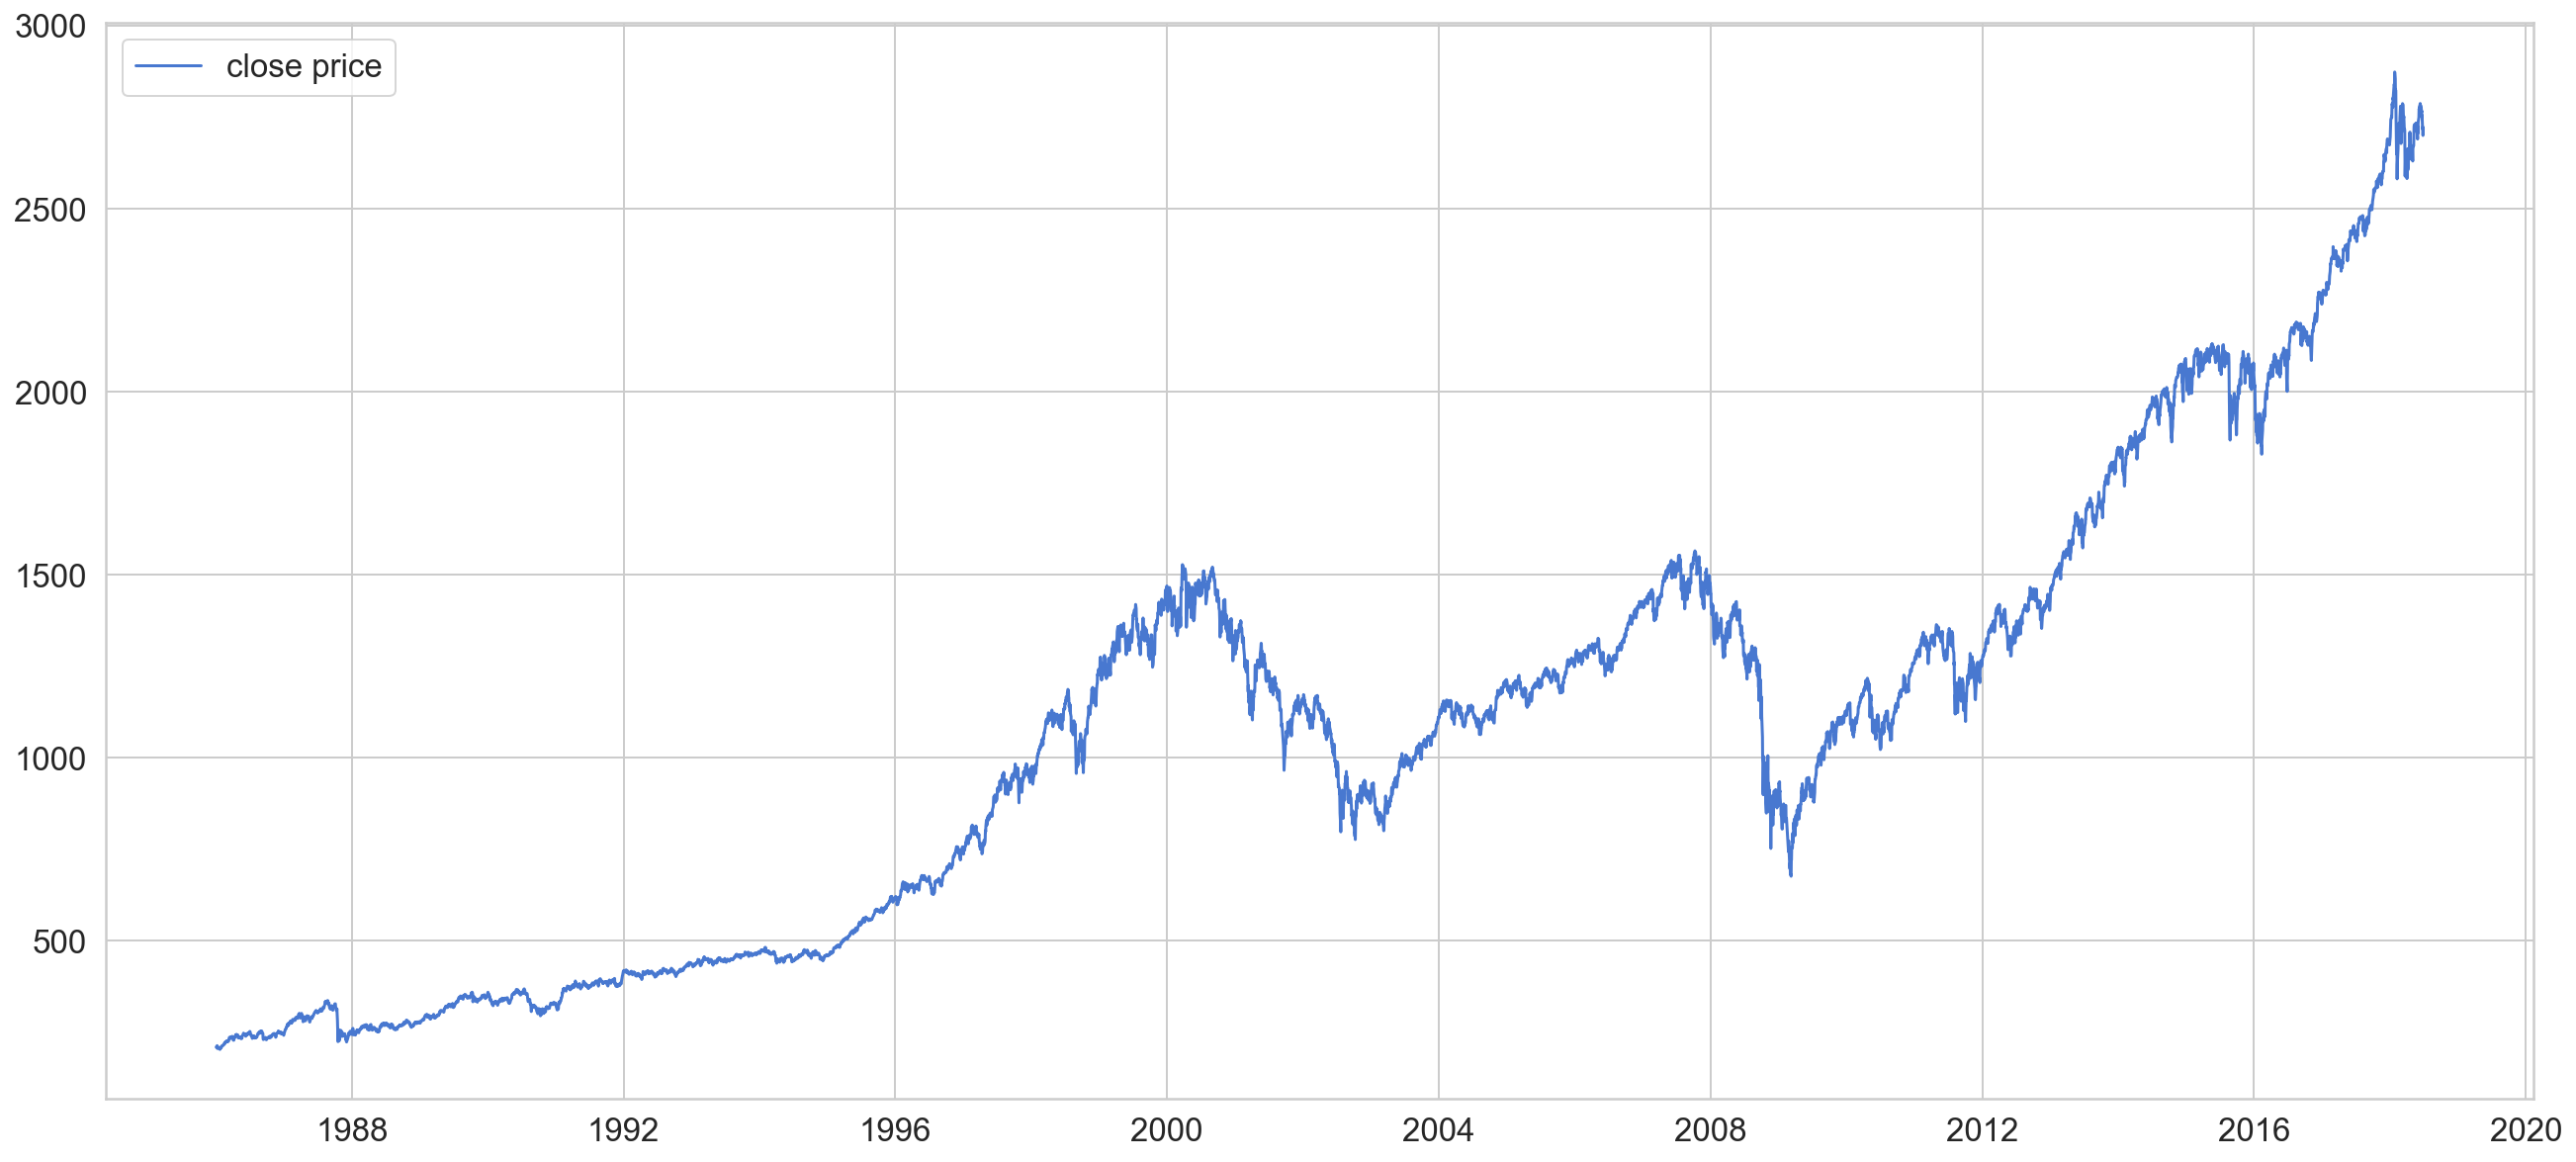

In [20]:
plt.plot(df, label='close price')
plt.legend();

In [147]:
df.shape

(8192, 1)

In [177]:
#train_size = int(len(df) * 0.95)
#test_size = len(df) - train_size

train_size = int(7500)
test_size = len(df) - (train_size)

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)-2]
print(train.shape, test.shape)

(7500, 1) (690, 1)


In [178]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

D:\Python35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Python35\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [179]:
train.head()

,close
date,
1986-01-02,-1.493478
1986-01-03,-1.490892
1986-01-06,-1.491353
1986-01-07,-1.485038
1986-01-08,-1.496726


In [180]:
train.shape, test.shape

((7500, 1), (690, 1))

In [181]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        vy = y.iloc[i:(i + time_steps)].values
        ys.append(vy)
    return np.array(Xs), np.array(ys)

In [182]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(
  train[['close']],
  train.close,
  TIME_STEPS
)

X_test, y_test = create_dataset(
  test[['close']],
  test.close,
  TIME_STEPS
)

print(X_train.shape)

(7470, 30, 1)


In [183]:
X_train.shape, y_train.shape

((7470, 30, 1), (7470, 30))

In [184]:
X_test.shape, y_test.shape

((660, 30, 1), (660, 30))

In [185]:
# X_train = X_train.reshape(X_train.shape[0], 1, TIME_STEPS)

In [186]:
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

In [187]:
X_train.shape, y_train.shape

((7470, 30, 1), (7470, 30, 1))

In [188]:
# model
import keras
from keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense

model = keras.Sequential()
model.add(LSTM(60, batch_input_shape=(TIME_STEPS, X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(RepeatVector(n=X_train.shape[1]))
model.add(LSTM(60, return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(units=X_train.shape[2])))

model.compile(loss='mae', optimizer='adam')

In [189]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=TIME_STEPS,
    shuffle=False
)

Epoch 1/10
7470/7470 [==============================] - 14s 2ms/step - loss: 0.1847
Epoch 2/10
7470/7470 [==============================] - 10s 1ms/step - loss: 0.1242
Epoch 3/10
7470/7470 [==============================] - 10s 1ms/step - loss: 0.1011
Epoch 4/10
7470/7470 [==============================] - 11s 1ms/step - loss: 0.1039: 0s - 
Epoch 5/10
7470/7470 [==============================] - 11s 1ms/step - loss: 0.1073
Epoch 6/10
7470/7470 [==============================] - 13s 2ms/step - loss: 0.1078
Epoch 7/10
7470/7470 [==============================] - 12s 2ms/step - loss: 0.1120: 0s - loss: 0
Epoch 8/10
7470/7470 [==============================] - 12s 2ms/step - loss: 0.1188
Epoch 9/10
7470/7470 [==============================] - 13s 2ms/step - loss: 0.1171
Epoch 10/10
7470/7470 [==============================] - 13s 2ms/step - loss: 0.1179


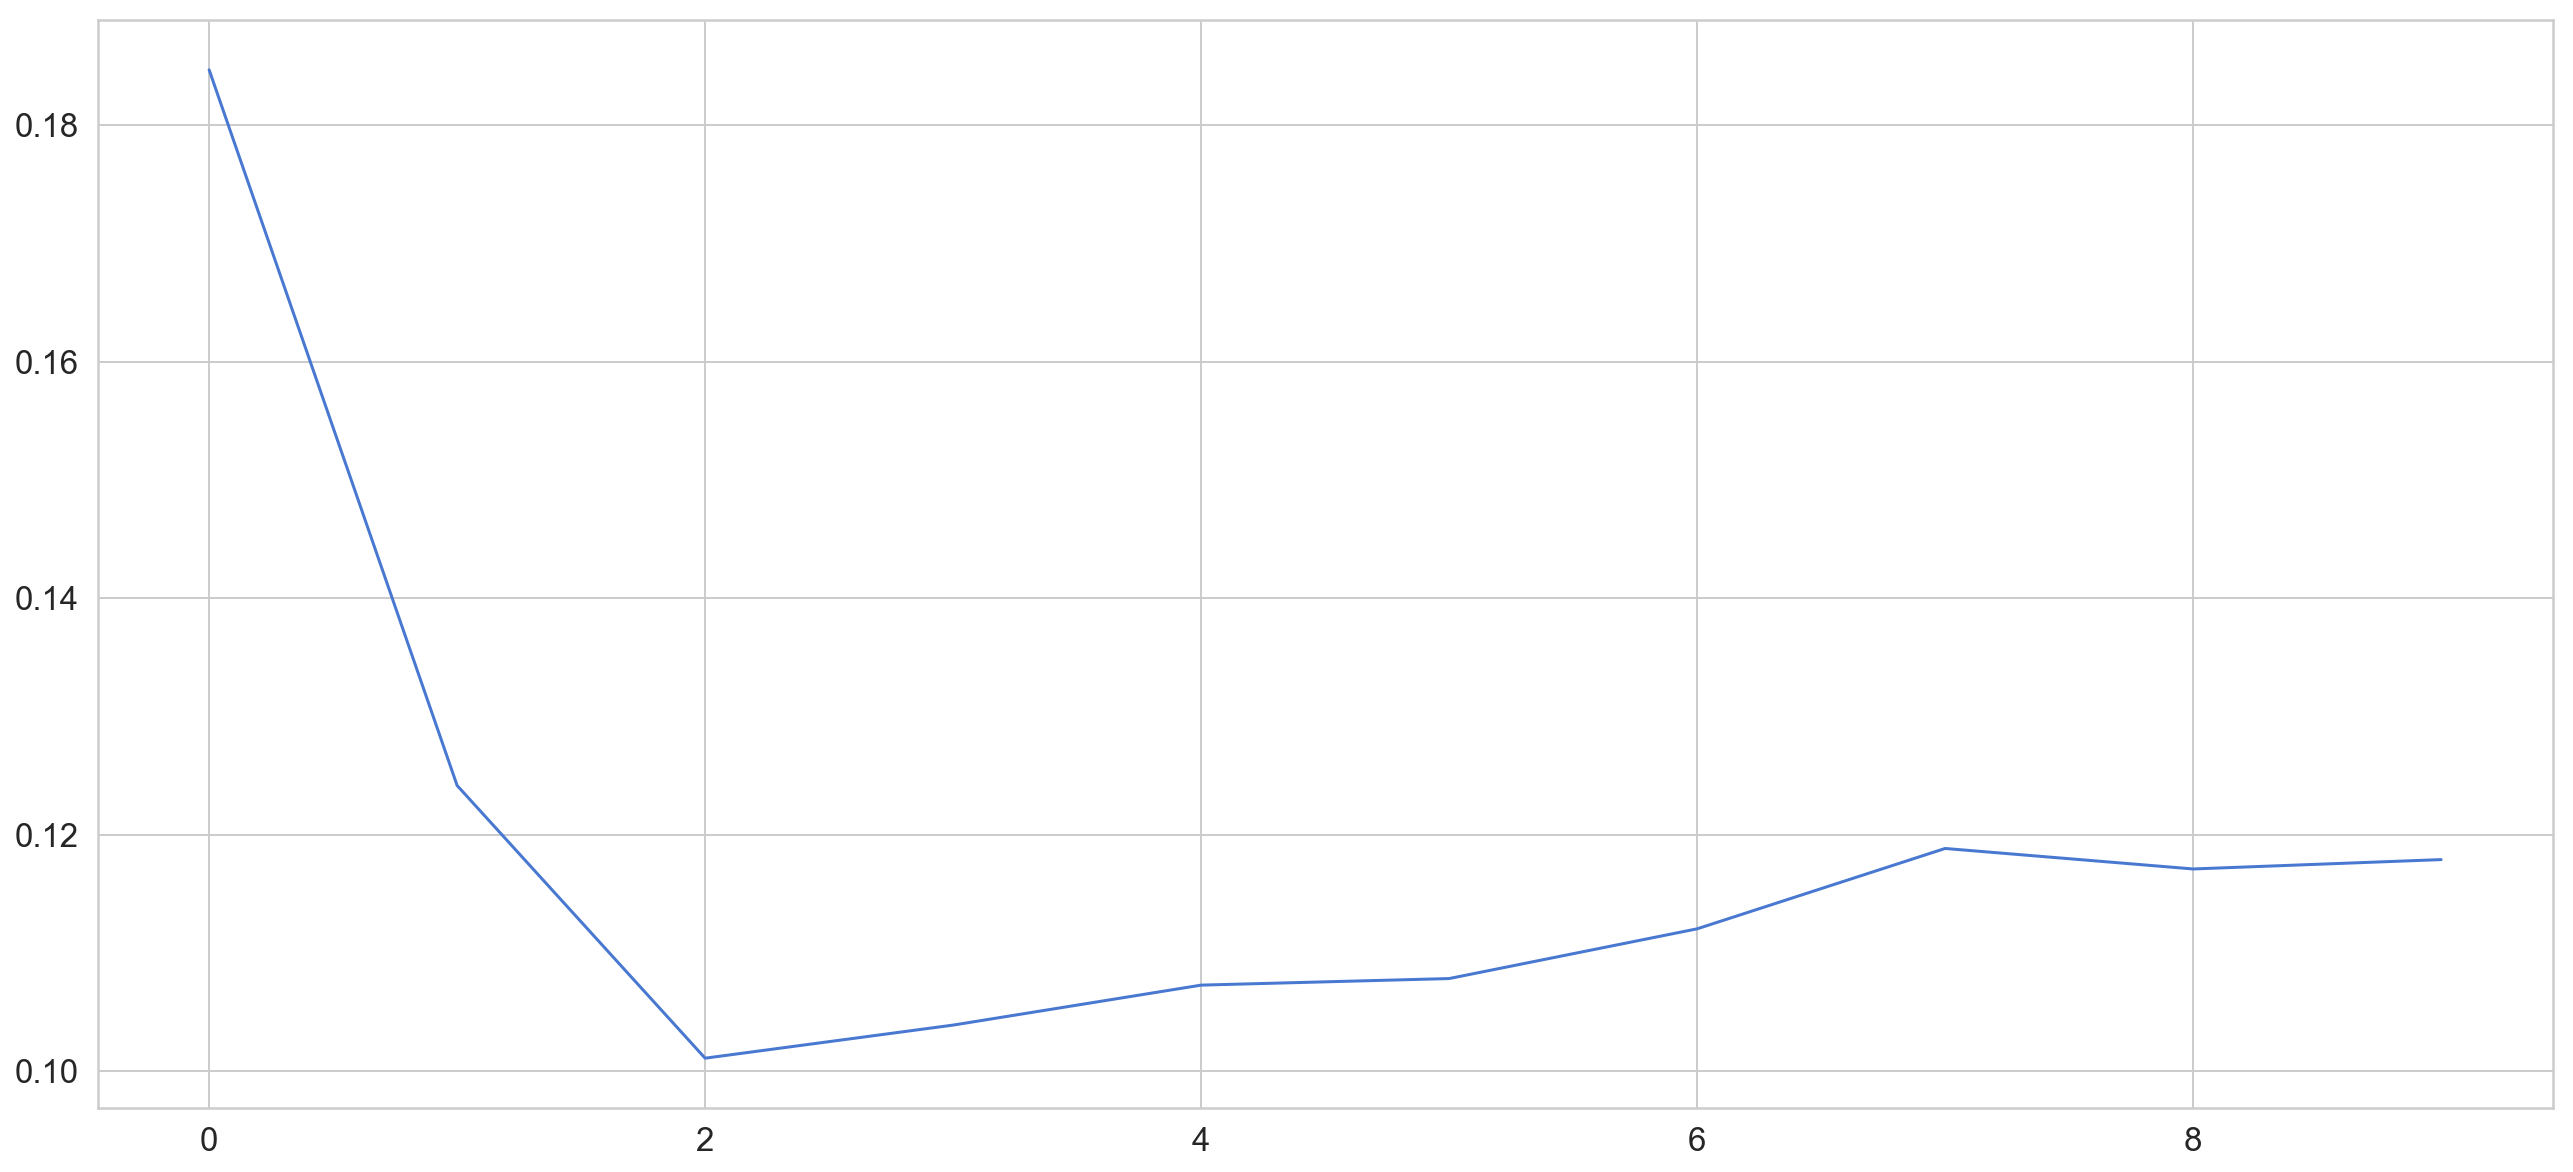

In [190]:
plt.plot(history.history['loss'])

In [192]:
X_train_pred = model.predict(X_train, batch_size=TIME_STEPS)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

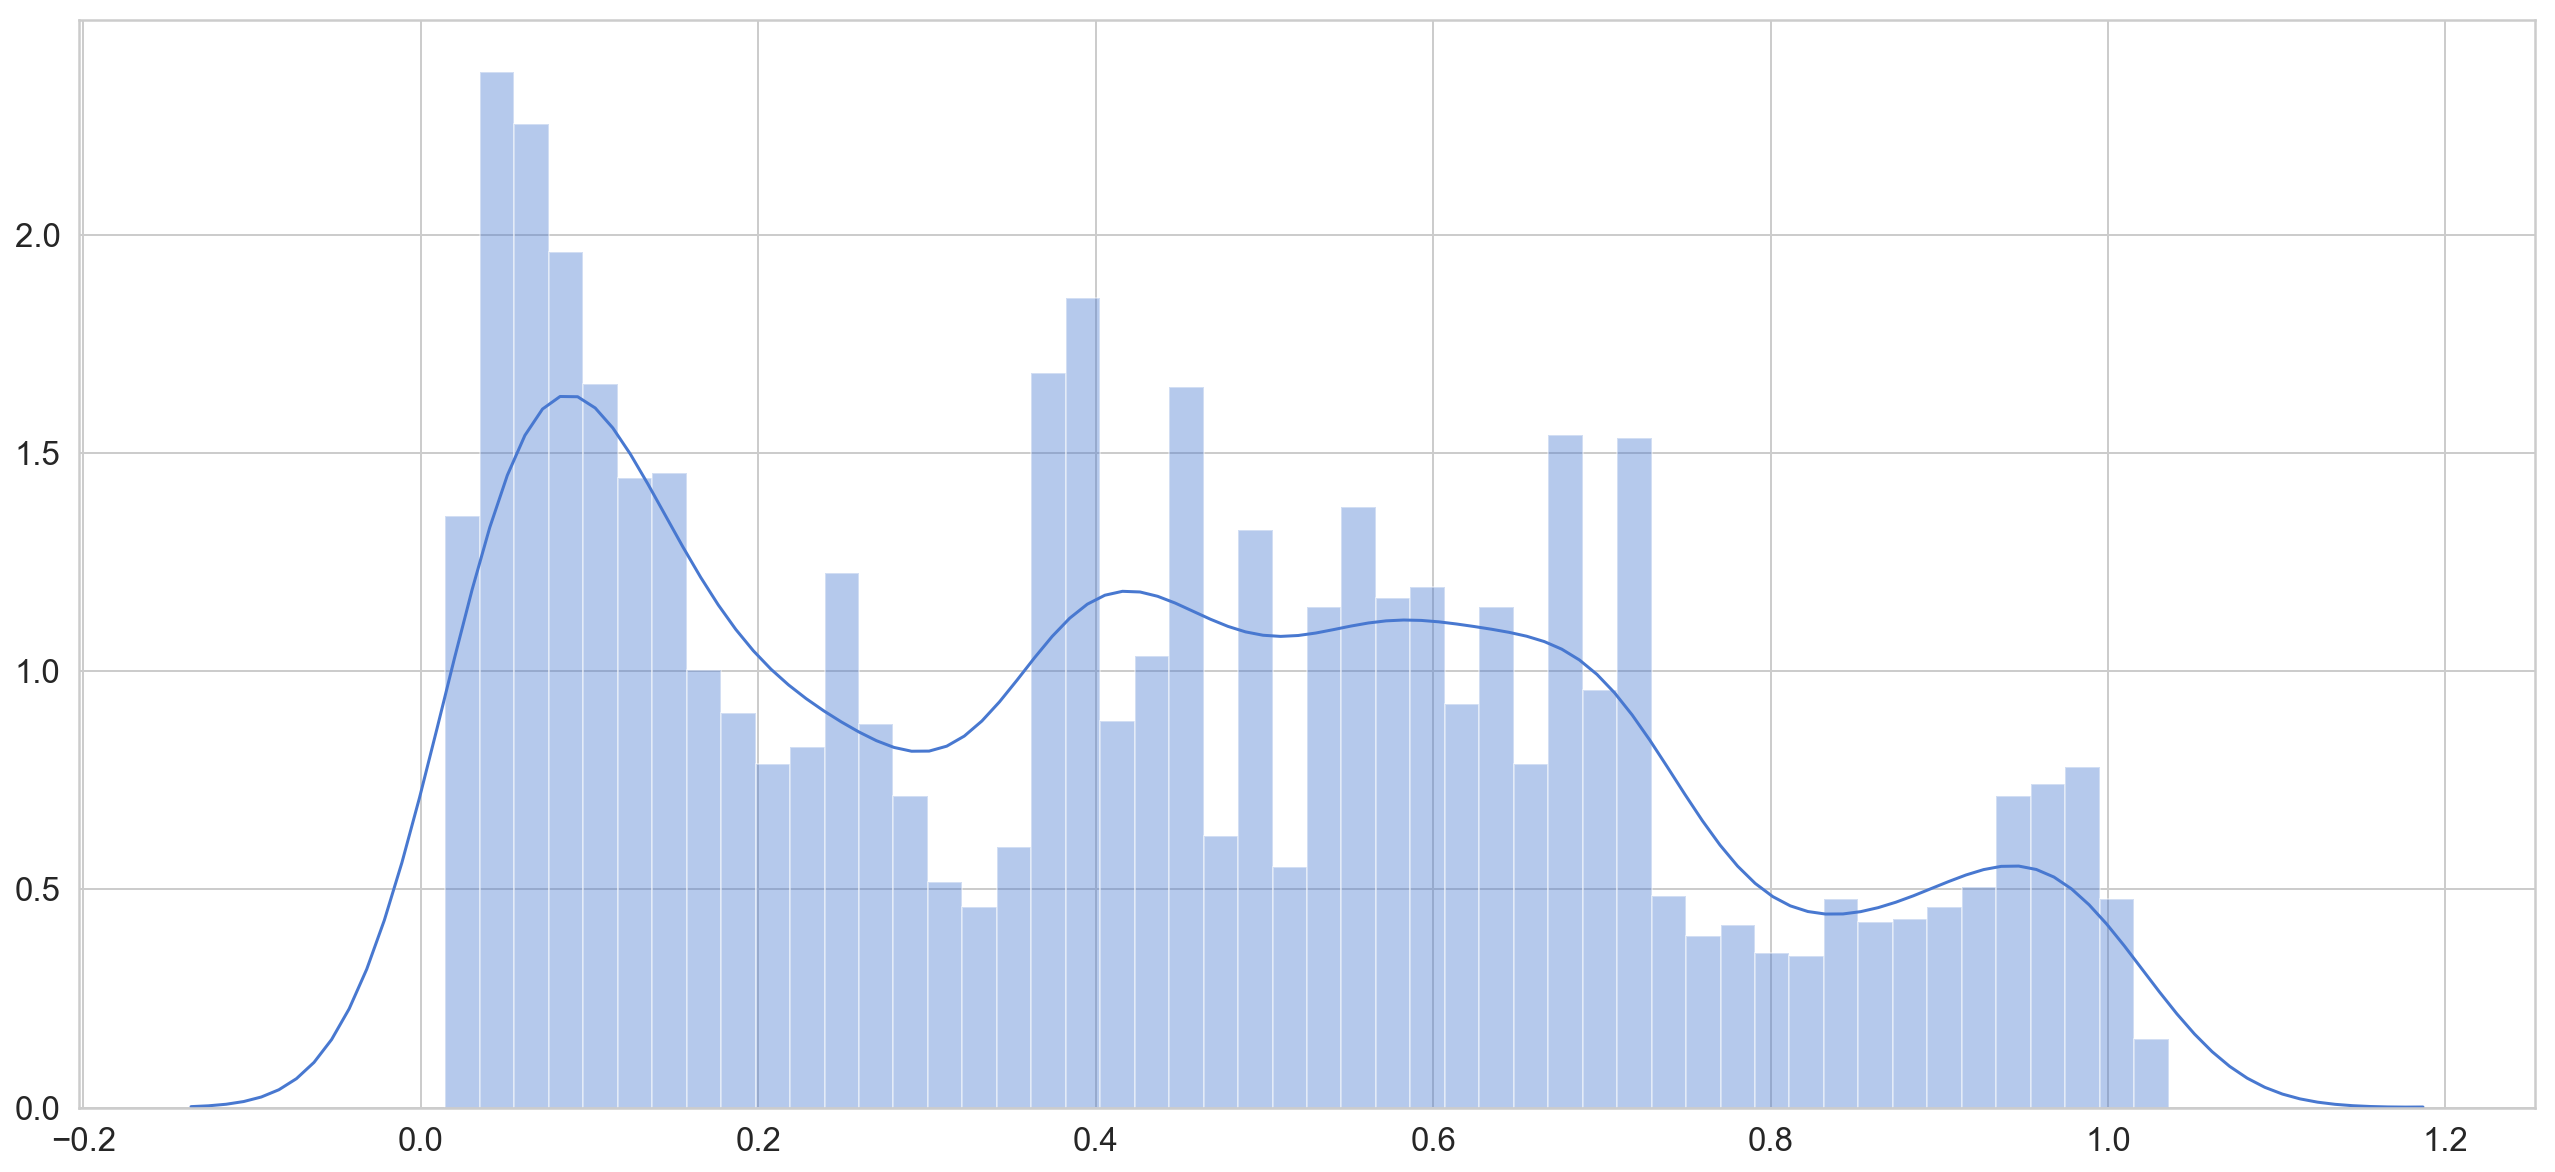

In [203]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [193]:
THRESHOLD = 0.65

In [194]:
X_test_pred = model.predict(X_test, batch_size=TIME_STEPS)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [195]:
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

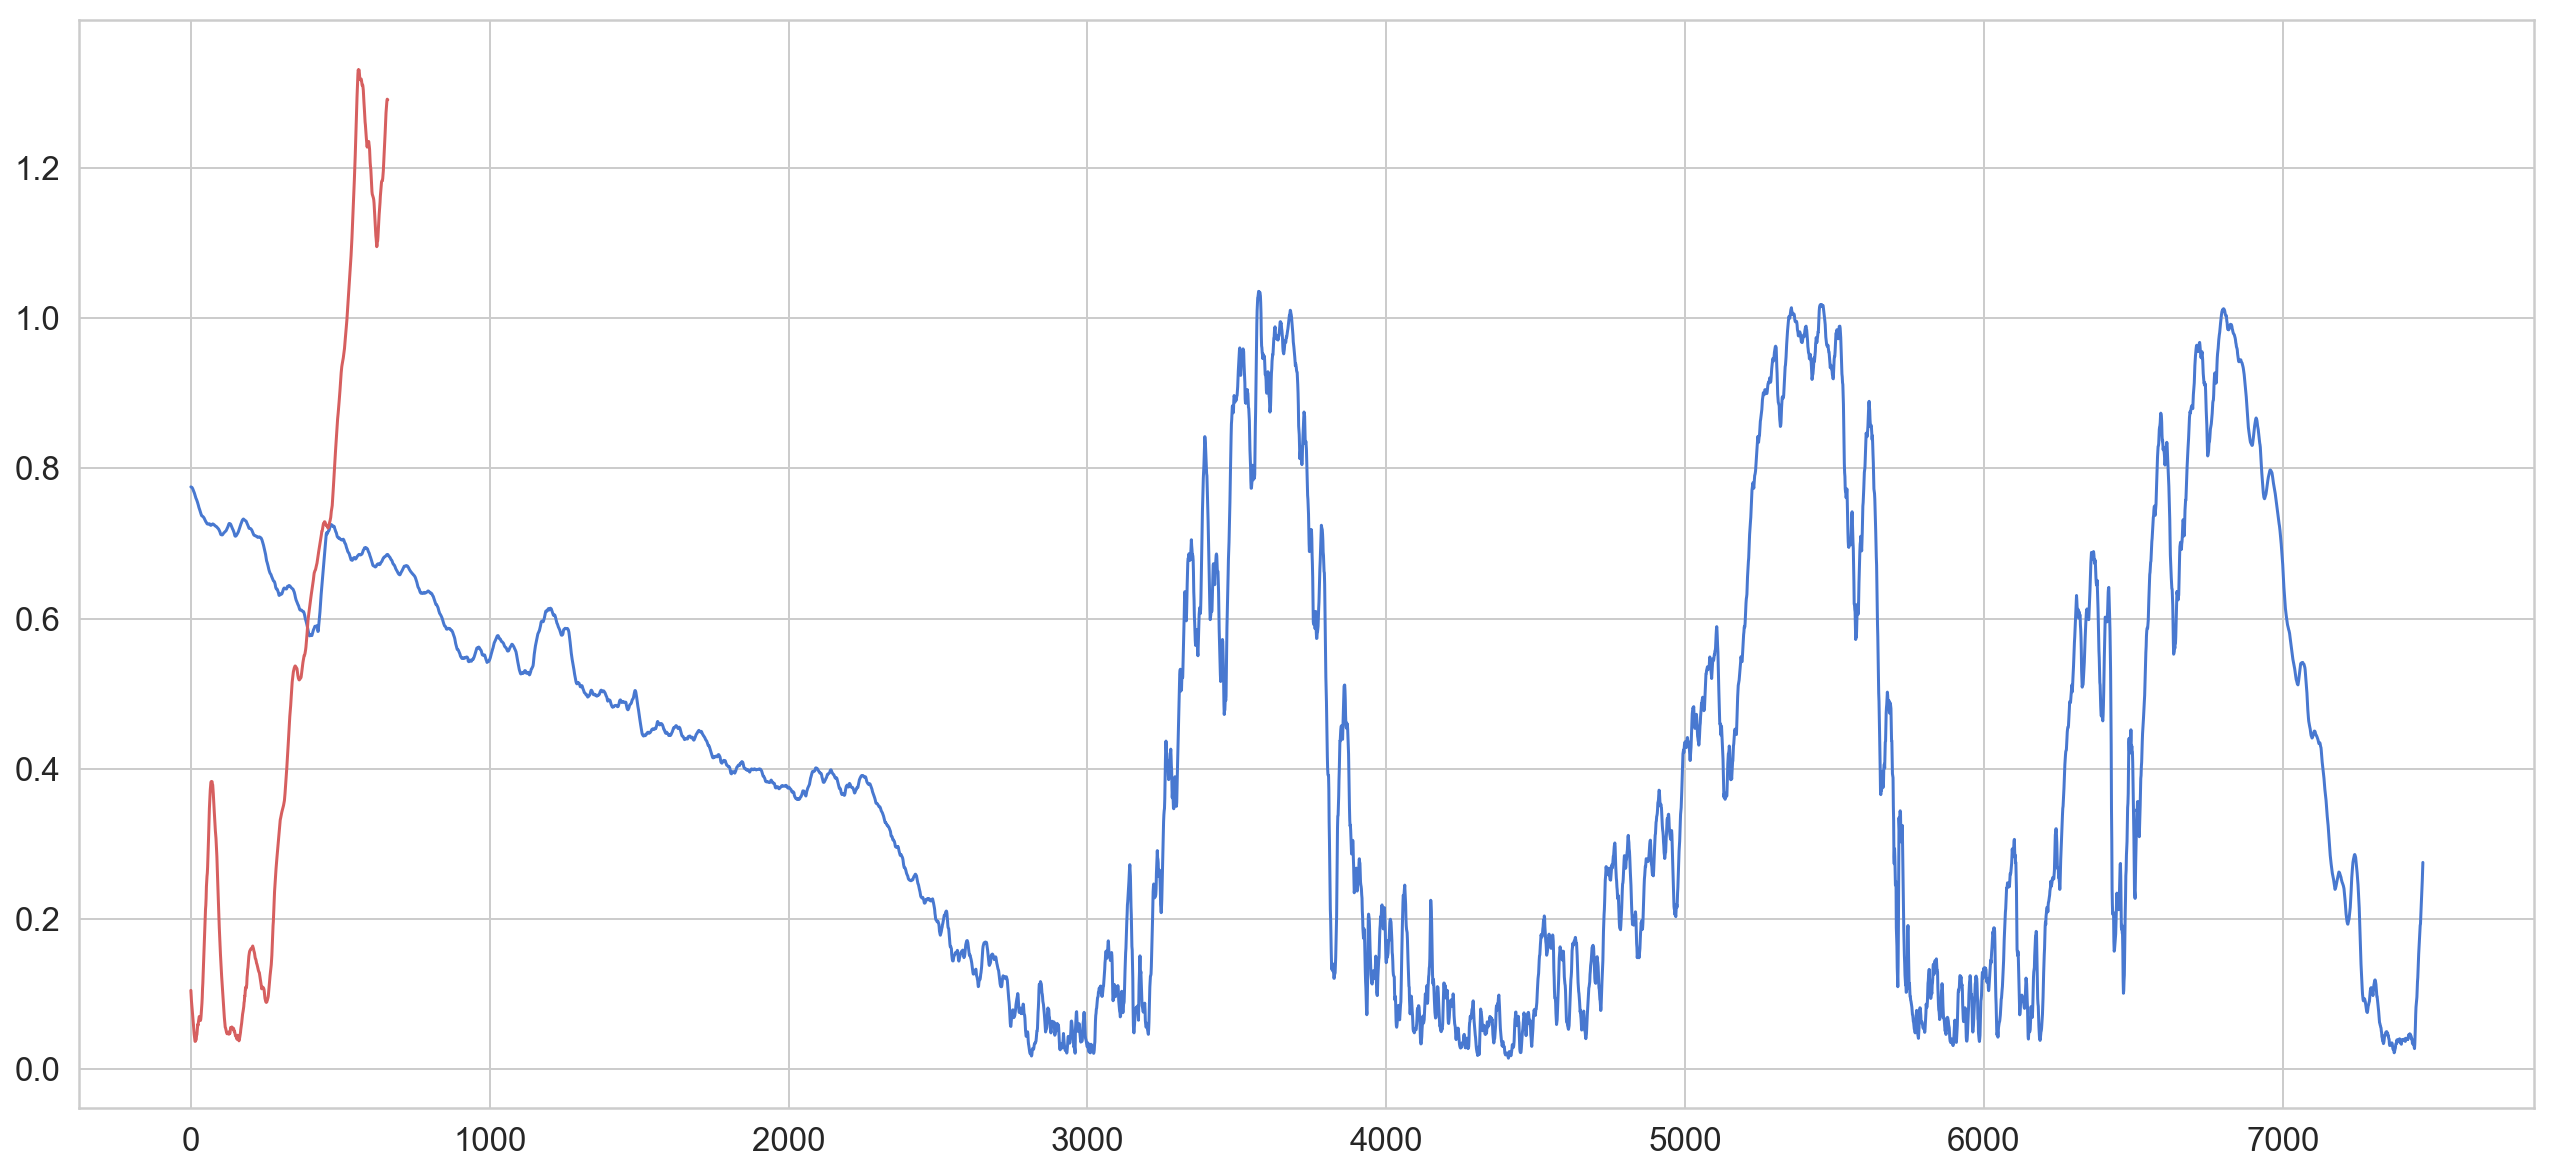

In [201]:
plt.plot(train_mae_loss)
plt.plot(test_mae_loss, color='r')

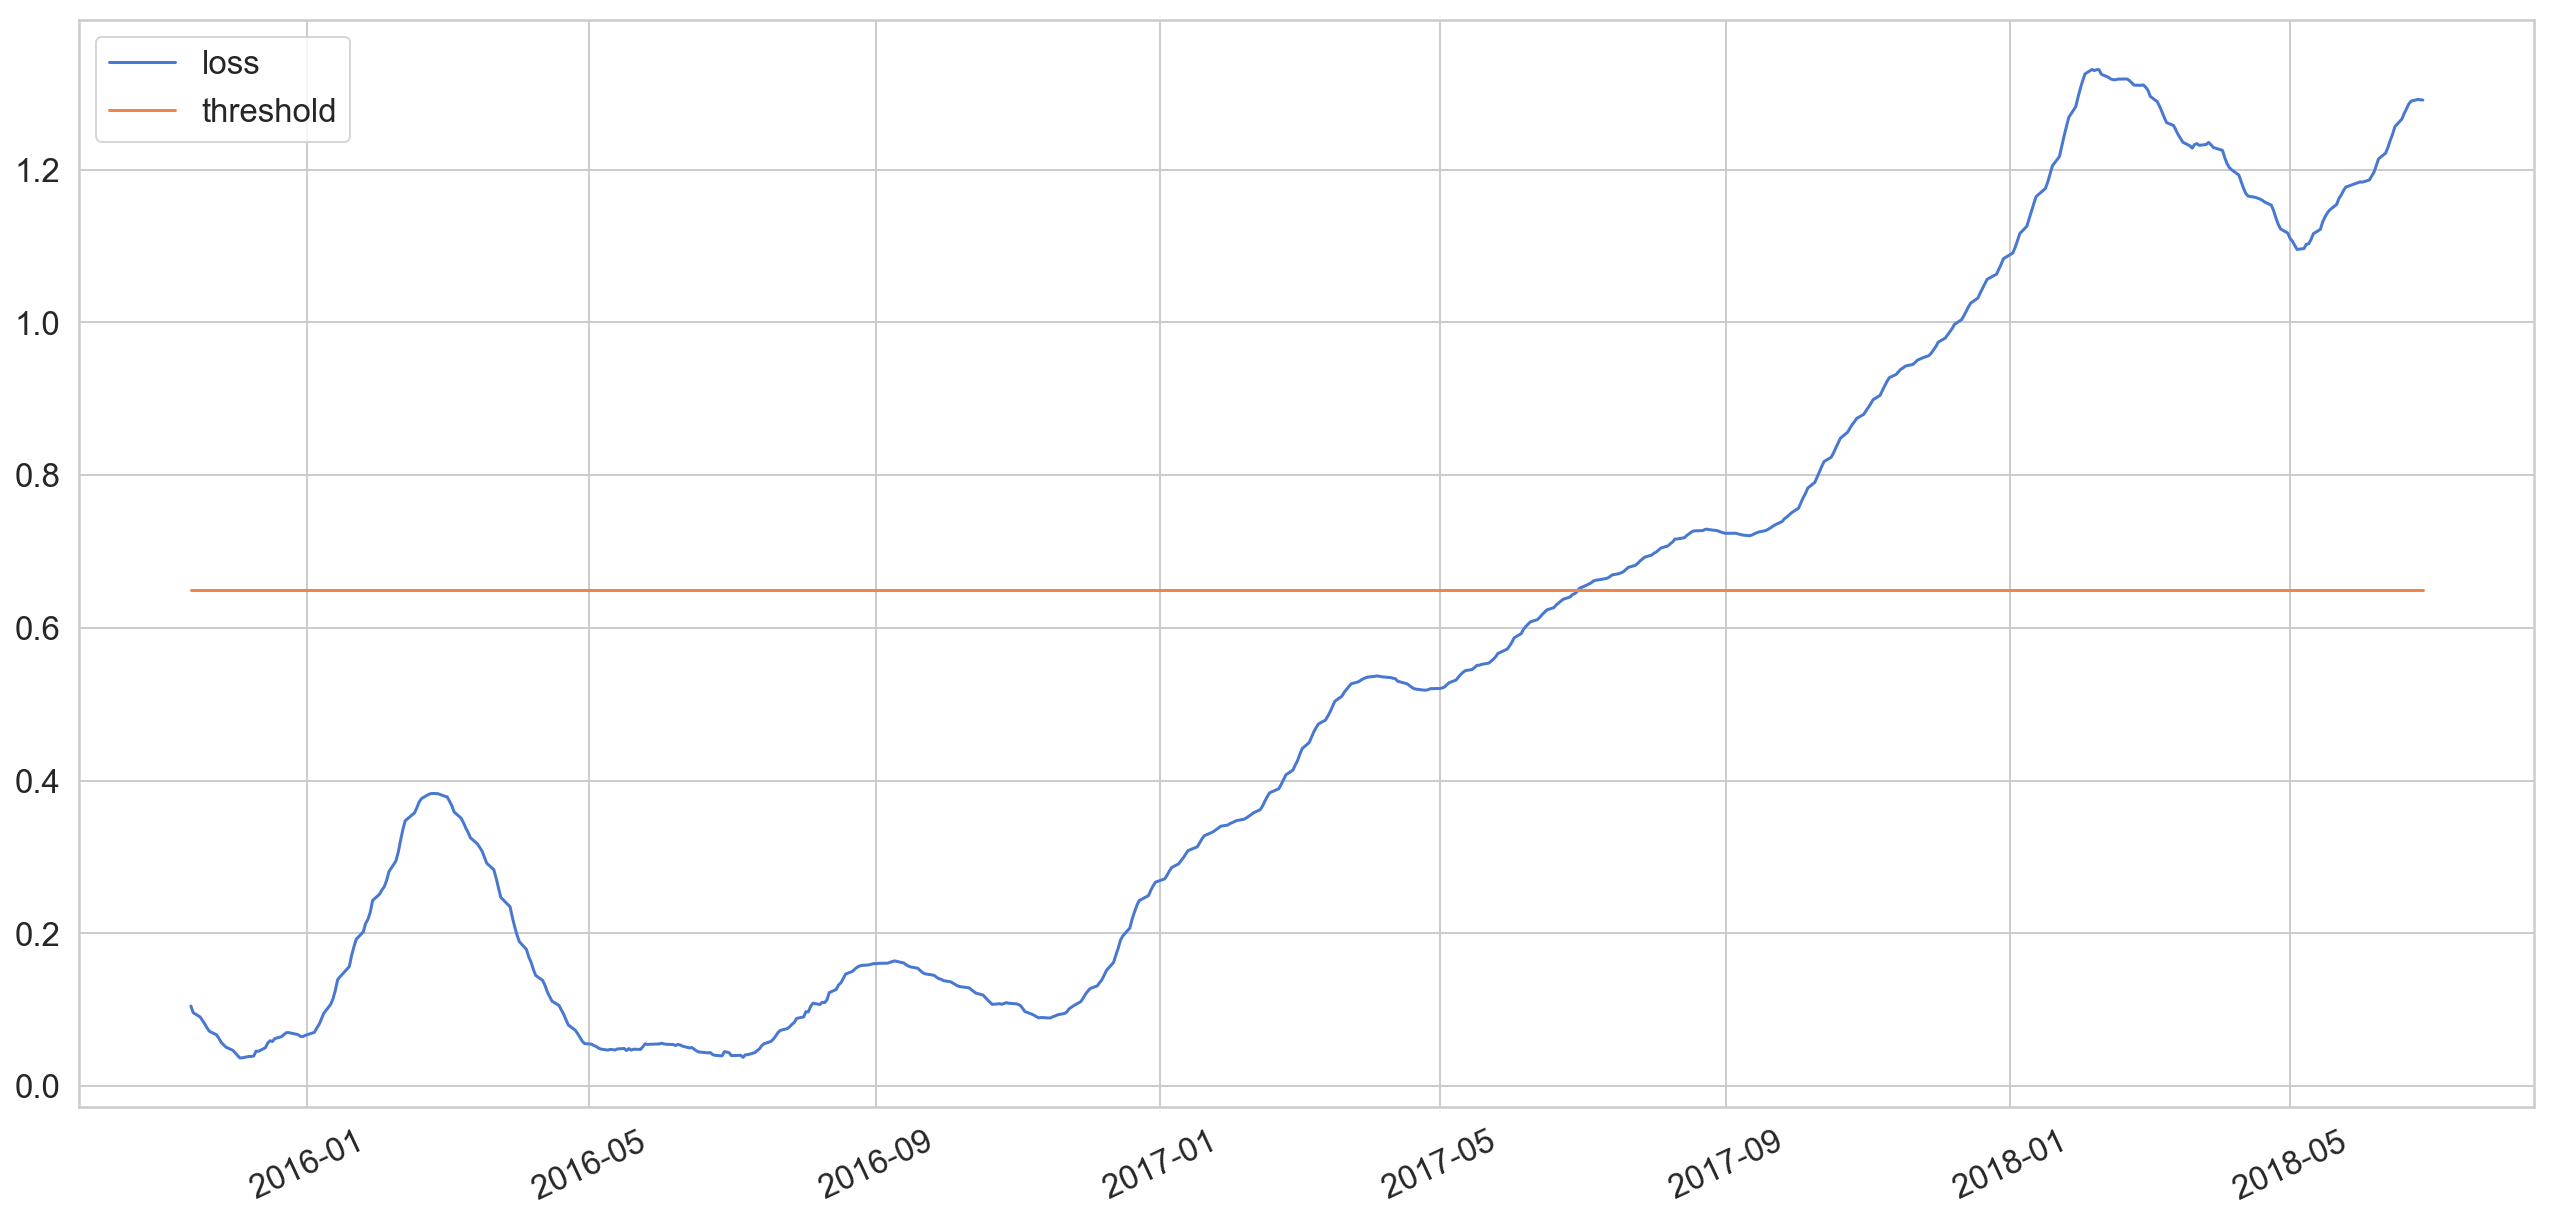

In [204]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [207]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2017-06-30,0.651823,0.65,True,2.944732
2017-07-03,0.655759,0.65,True,2.955958
2017-07-05,0.658900,0.65,True,2.963035
2017-07-06,0.661421,0.65,True,2.917346
2017-07-07,0.662317,0.65,True,2.948280


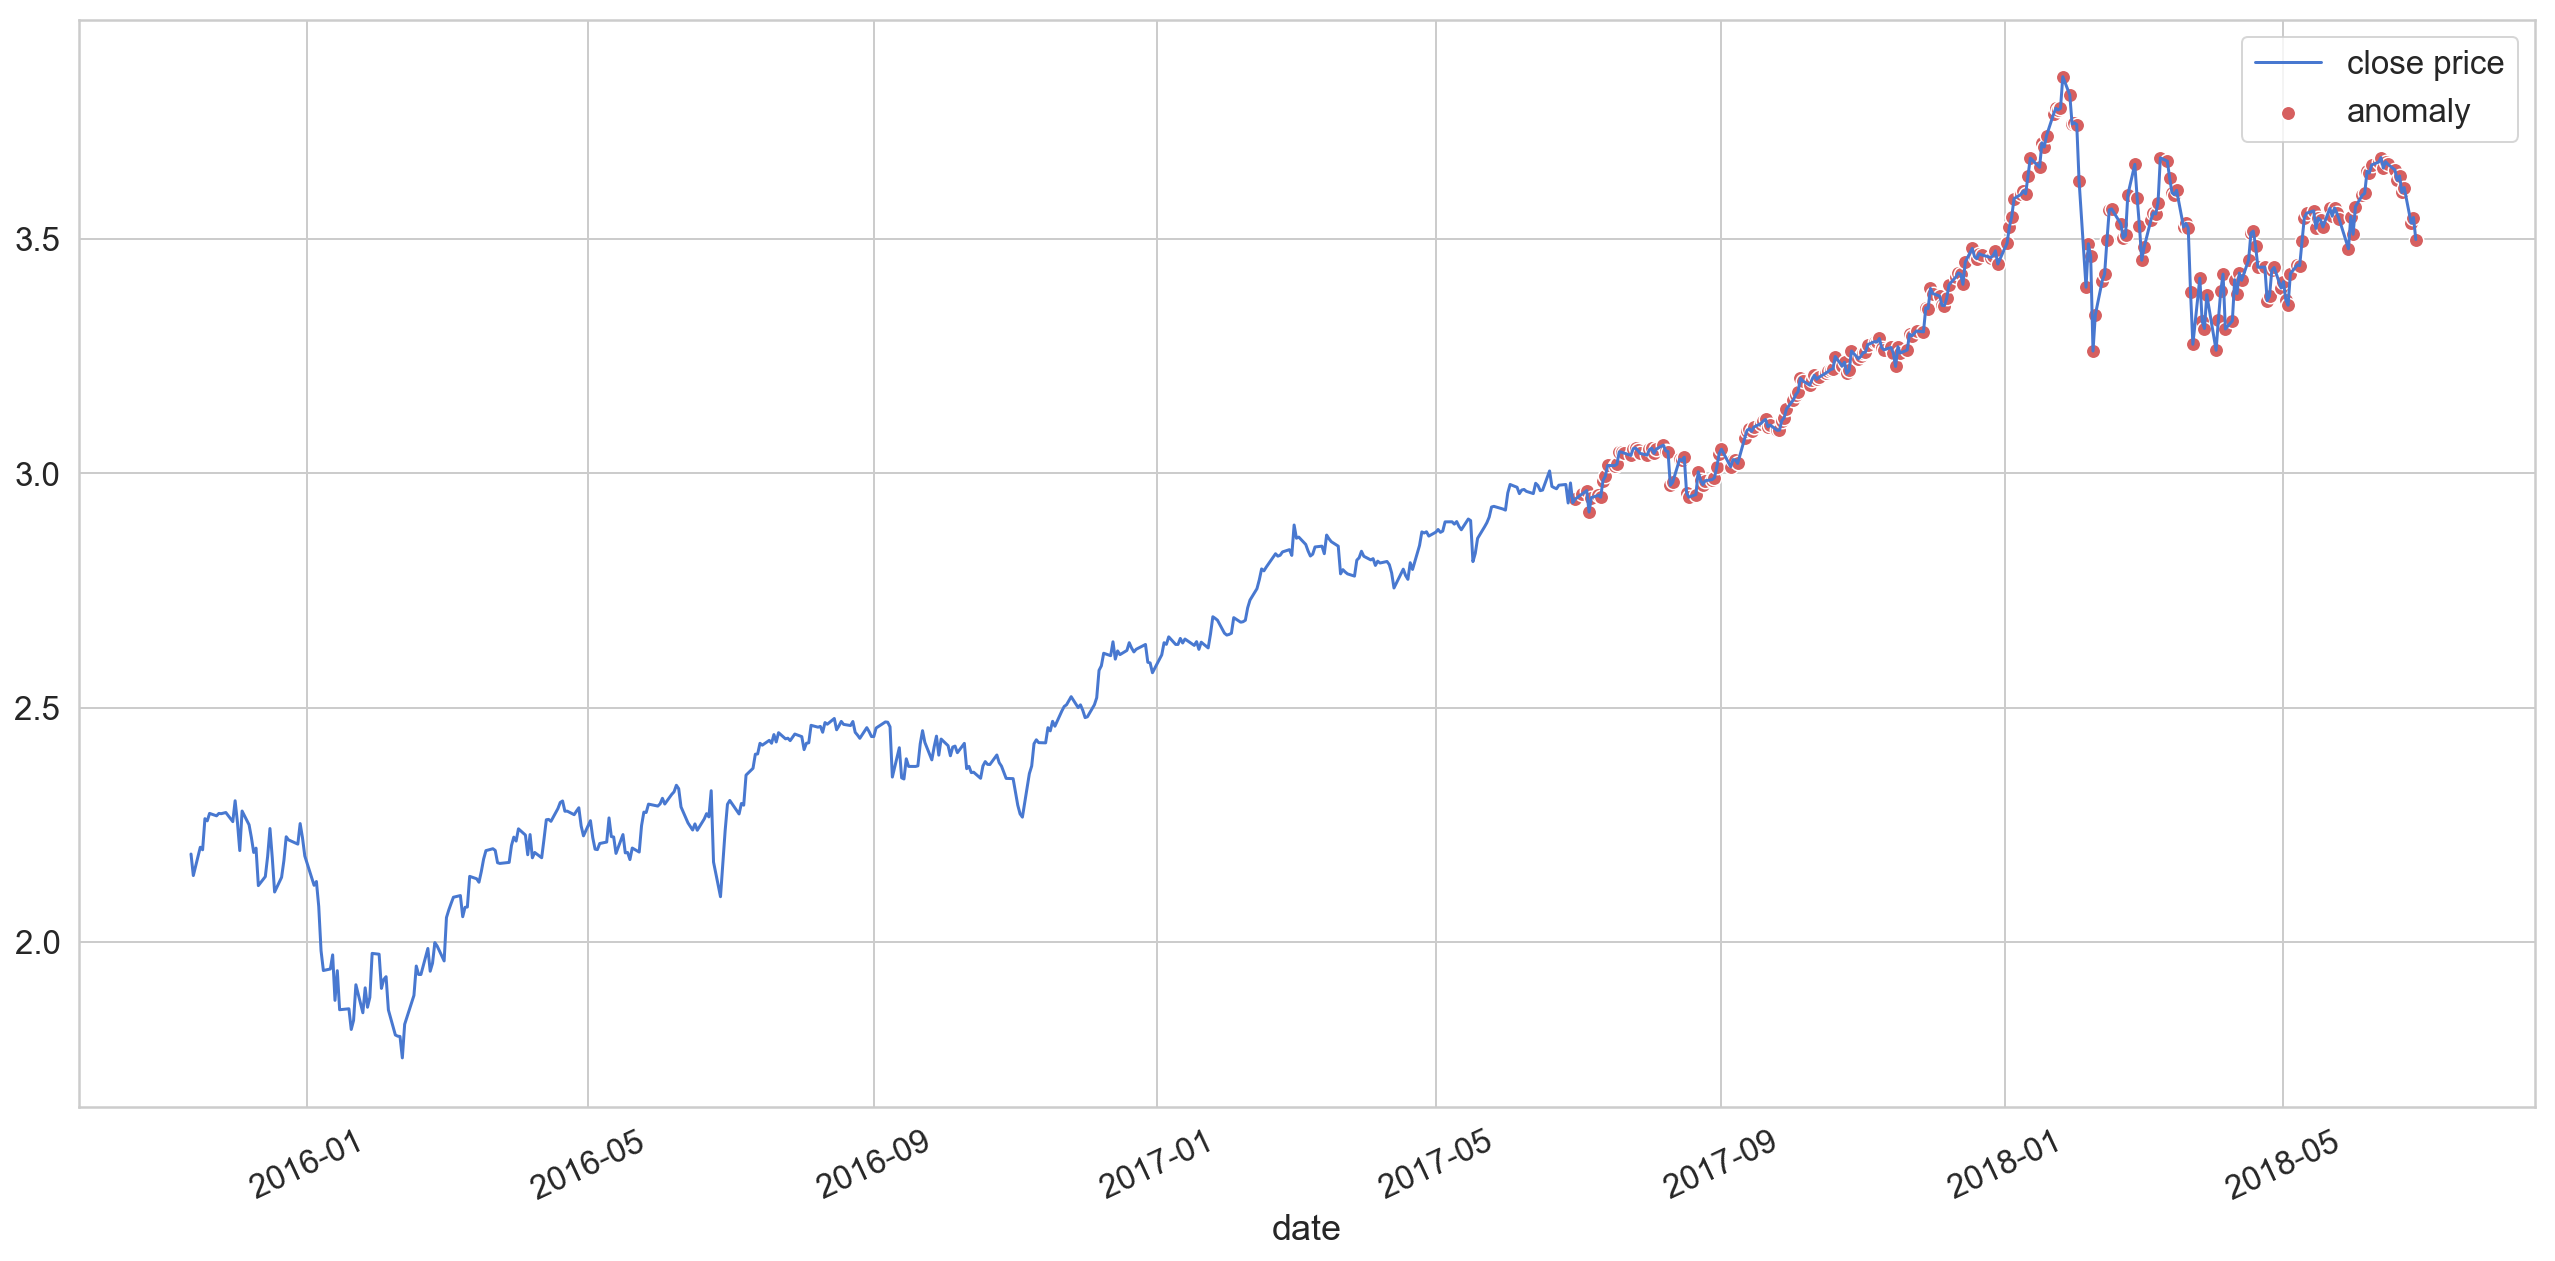

In [206]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

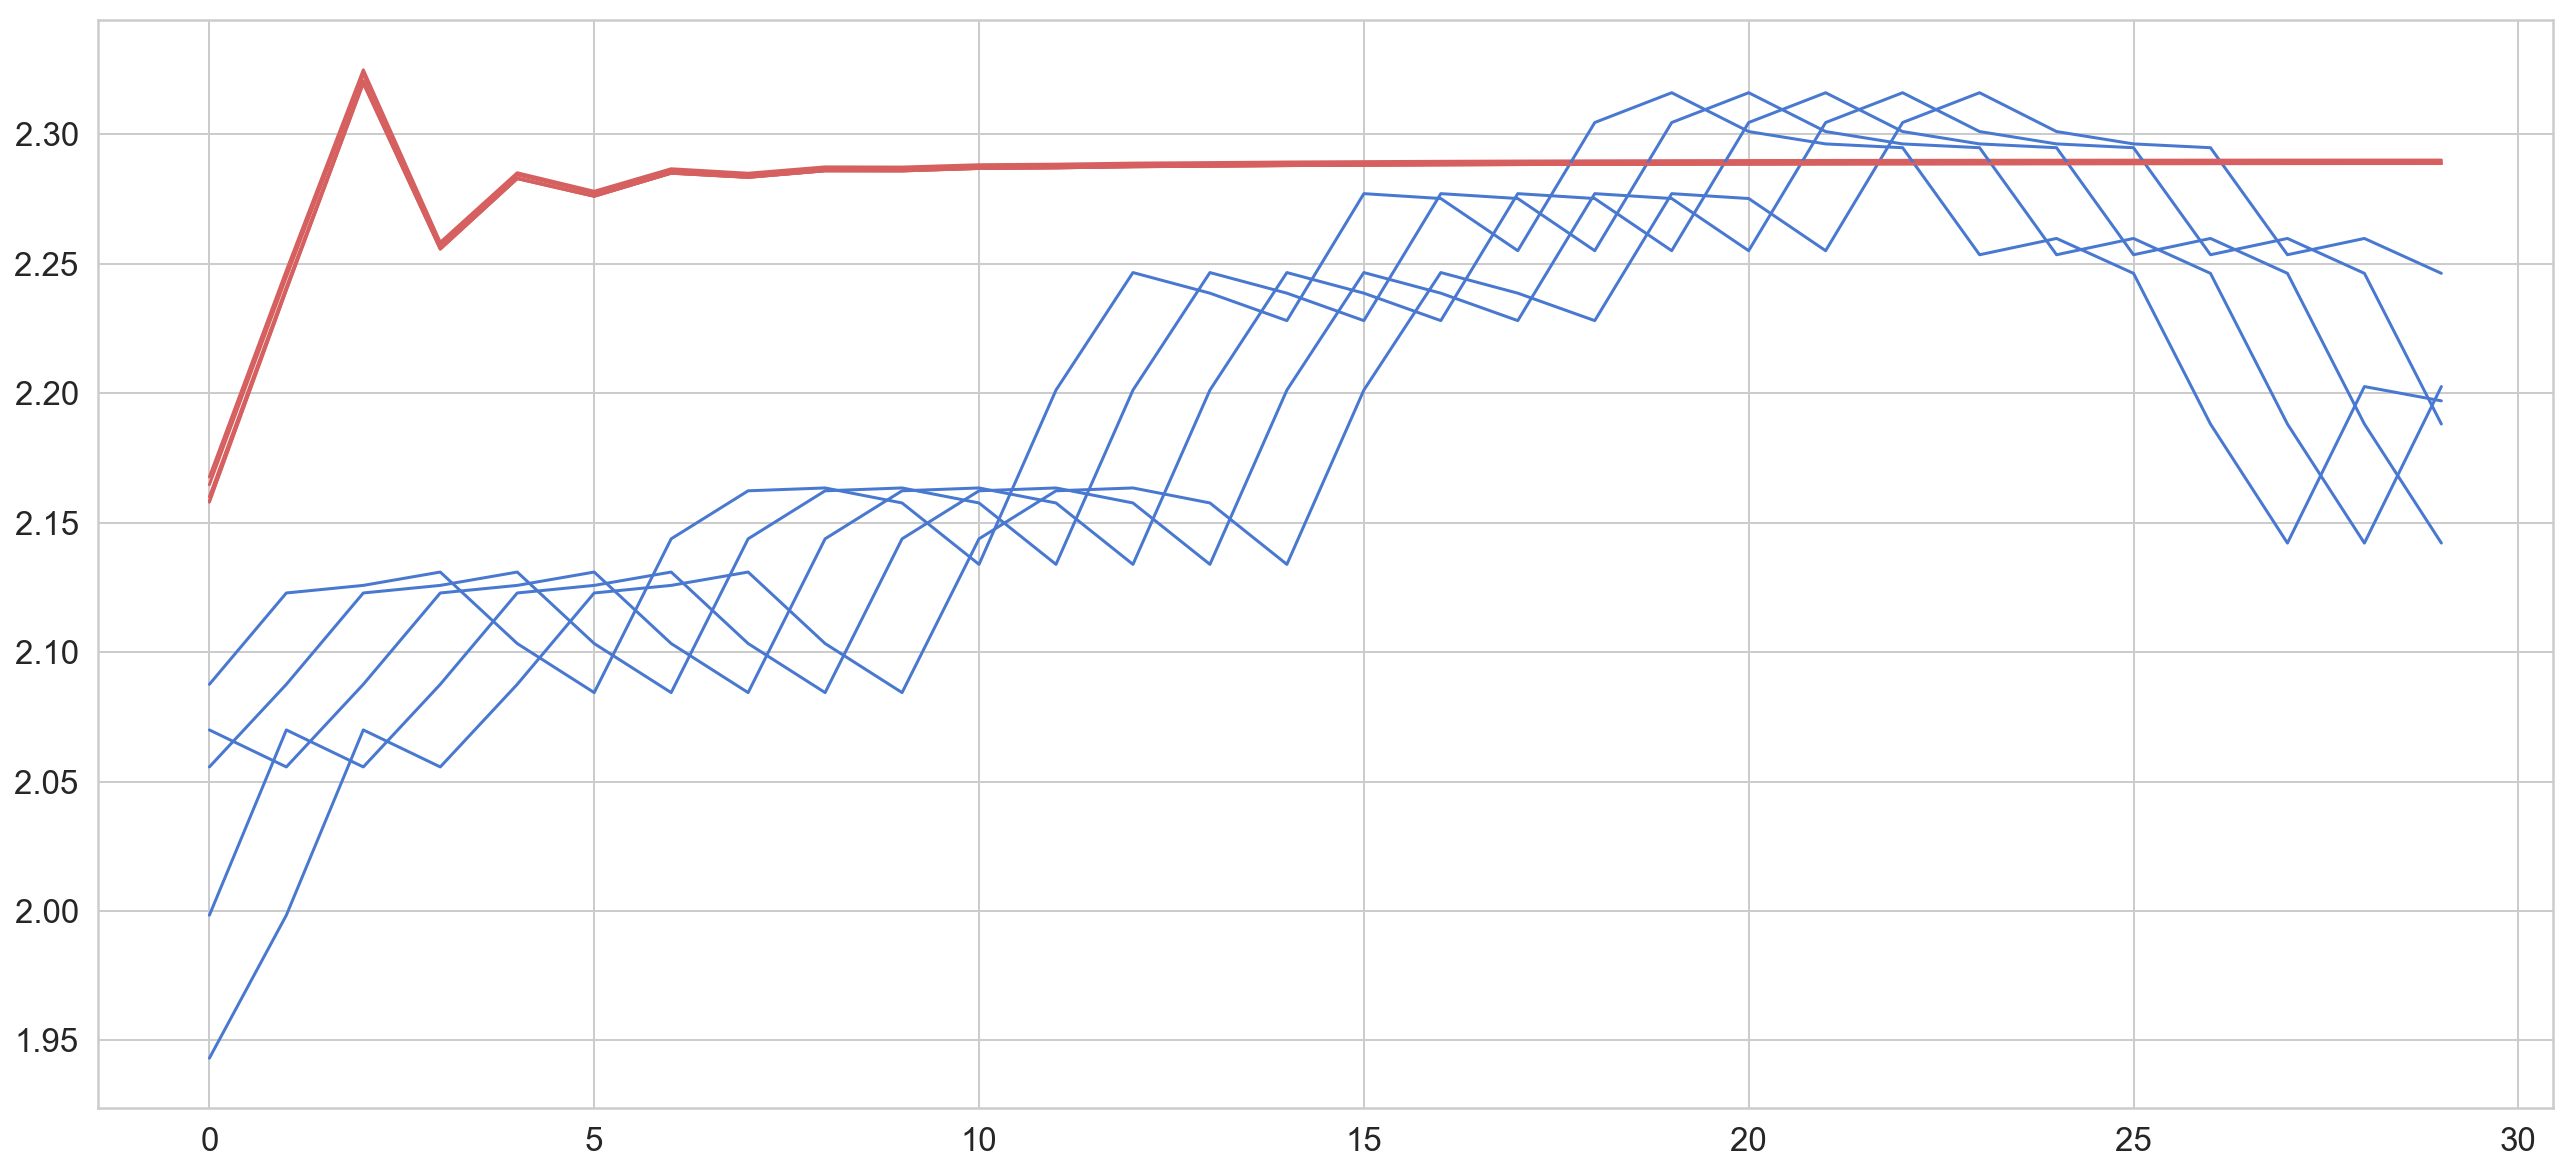

In [220]:
for i in range(0, 5):
    plt.plot(X_test[i], color='b')
    plt.plot(X_test_pred[i], color='r')